In [1]:
import torch
import os



# GPU 할당 변경하기
GPU_NUM = 4  # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check



Current cuda device  4


In [2]:
import time
import math
import random
import librosa
import librosa.display
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix as cm
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset


''''''
BATCH_SIZE = 20
EPOCHS = 100
lr = 2*10e-5
''''''

path = ''


In [3]:

x_data = torch.load( '0818data.pt' ).to('cpu')
y_data = torch.load( '0818label.pt').to('cpu')


#### data augmentation (flip)

In [4]:

def flip(y_data):
    y_flipped = torch.empty(2000,)
    
    for idx in range(len(y_data)):
        y = int(y_data[idx])
        if   y == 10:   y_flipped[idx] = y_data[idx]
        else        :   y_flipped[idx] = 9-y_data[idx]
    
    return y_flipped


In [5]:
print( 'x_data: ', x_data.shape )
print( 'y_data: ', y_data.shape )

x_data:  torch.Size([2000, 4, 257, 382])
y_data:  torch.Size([2000])


In [6]:
S_left  = x_data[:,0,:,:].reshape(2000, 1, 257, 382)
S_right = x_data[:,1,:,:].reshape(2000, 1, 257, 382)
S_left_phase  = x_data[:,2,:,:].reshape(2000, 1, 257, 382)
S_right_phase = x_data[:,3,:,:].reshape(2000, 1, 257, 382)

print(S_left.shape)
print(S_right.shape)
print(S_left_phase.shape)
print(S_right_phase.shape)


torch.Size([2000, 1, 257, 382])
torch.Size([2000, 1, 257, 382])
torch.Size([2000, 1, 257, 382])
torch.Size([2000, 1, 257, 382])


In [7]:
S_l = torch.cat([S_left, S_right],dim=0)
S_r = torch.cat([S_right, S_left],dim=0)
S_l_p = torch.cat([S_left_phase, S_right_phase],dim=0)
S_r_p = torch.cat([S_left_phase, S_right_phase],dim=0)

print(S_l.shape)
print(S_r.shape)
print(S_l_p.shape)
print(S_r_p.shape)


torch.Size([4000, 1, 257, 382])
torch.Size([4000, 1, 257, 382])
torch.Size([4000, 1, 257, 382])
torch.Size([4000, 1, 257, 382])


In [8]:

y_flipped = flip(y_data)


x_data = torch.cat([S_l, S_r, S_l_p, S_r_p],dim=1)
y_data = torch.cat([y_data, y_flipped], dim=0)

x_data = ( x_data[:,:2,:,:] ).float().to(device)
y_data = ( y_data ).long().to(device)

print( 'x_data: ', x_data.shape )
print( 'y_data: ', y_data.shape )


x_data:  torch.Size([4000, 2, 257, 382])
y_data:  torch.Size([4000])


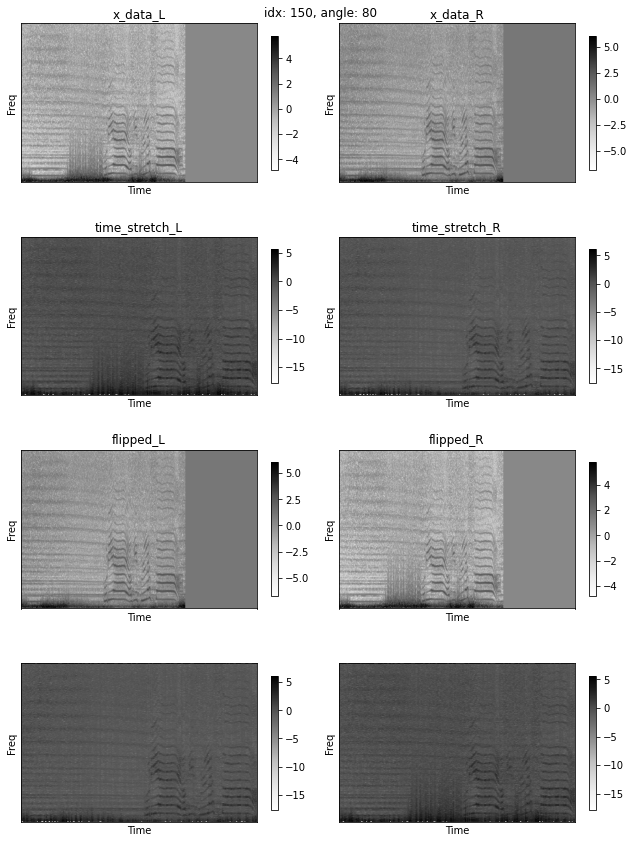

In [9]:

# data 확인
idx = 150


x0 = np.asarray( x_data[idx-1][0].to('cpu') )
x1 = np.asarray( x_data[idx-1][1].to('cpu') )
x2 = np.asarray( x_data[idx-1+1000][0].to('cpu') )
x3 = np.asarray( x_data[idx-1+1000][1].to('cpu') )

x4 = np.asarray( x_data[idx-1+2000][0].to('cpu') )
x5 = np.asarray( x_data[idx-1+2000][1].to('cpu') )
x6 = np.asarray( x_data[idx-1+3000][0].to('cpu') )
x7 = np.asarray( x_data[idx-1+3000][1].to('cpu') )

x = [x0, x1, x2, x3,  x4, x5, x6, x7]
title=['x_data_L', 'x_data_R', 'time_stretch_L','time_stretch_R', 'flipped_L', 'flipped_R','','']


fig = plt.figure(figsize=(9,3*4))
fig.suptitle("idx: {}, angle: {}".format(idx, y_data[idx-1]*20))
row, col = 4,2

for i,mag in enumerate(x):
    ax = fig.add_subplot(row, col, i+1)
    im = ax.imshow(mag, origin='lower', cmap='Greys')
    ax.set_title(title[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Freq')
    ax.set_xticks([]), ax.set_yticks([])
    fig.colorbar(im, shrink=0.7)

plt.tight_layout()
plt.savefig('data2.png')
plt.show()


In [10]:

train_size = 800*4 + 200*3
valid_size = 200


full_dataset = TensorDataset( x_data, y_data )

train_data, valid_data = torch.utils.data.random_split( full_dataset, [train_size, valid_size] )
train_dataset = DataLoader( dataset=train_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
valid_dataset = DataLoader( dataset=valid_data, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)


#### DenseNet

In [11]:

from collections import OrderedDict
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate,
                                           kernel_size=1, stride=1,bias=False)),
        
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        
        return bottleneck_output


    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input


        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        
        return new_features




class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)





class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features,
                                          num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))




class DenseNet(nn.Module):
    '''growth_rate, drop_rate'''
    def __init__(self, growth_rate=20, block_config=(6, 12, 24, 16),
                 num_init_features=128, bn_size=4, drop_rate=0.10,
                 num_classes=11, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(2, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))


        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)



    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out





def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress, **kwargs):
    return DenseNet(growth_rate, block_config, num_init_features, **kwargs)



def densenet_custom(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet_custom', 64, (5, 5, 4), 64, pretrained, progress, **kwargs)



In [12]:
# DataParallel

#model = CNN().to(device)
#model = Resnet().to(device)
model = densenet_custom()
model = nn.DataParallel(model, device_ids=[4,5])
model = model.cuda()


#### train

In [13]:

torch.manual_seed(100)
criterion = nn.CrossEntropyLoss().to(device)


'''optimizer'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
TITLE = 'Adam'




train_loss = []
train_acc  = []


# confusion matrix를 만들기 위해서 
# 먼저 int type의 random값이 있는 
# (1,) size torch tensor 초기화
torch_pred  = torch.empty((1,), dtype=torch.int32).to(device)
torch_label = torch.empty((1,), dtype=torch.int32).to(device)



model.train()
for epoch in range(EPOCHS):
    #print('epoch ' + str(epoch+1))
    total_loss = 0.0
    total_acc = 0
    start = time.time()
    
    for i, (data, label) in enumerate(train_dataset):
        (data, label) = (data.to(device), label.to(device))

        #zero the parameter gradients
        optimizer.zero_grad()        

        # forward + backward = optimize
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        

        """loss, accuracy"""
        # batch 정확도
        preds  = torch.max(output.data, 1)[1]
        corr  = (preds==label).sum().item()
        acc   = corr/BATCH_SIZE*100

        # epoch 손실도, 정확도
        total_loss += loss.item()
        total_acc += corr
    
        # batch 손실도, 정확도 출력, 저장
        #train_loss.append(loss)
        #train_acc.append(acc)


        """ confusion matrix"""
        # 마지막 epoch에서 
        if epoch == EPOCHS-1:
            torch_pred  = torch.cat( [ torch_pred , preds.to( device, dtype=torch.int32) ], dim=0 )
            torch_label = torch.cat( [ torch_label, label.to( device, dtype=torch.int32) ], dim=0 )

            
    # epoch 손실도, 정확도 출력
    train_loss.append(total_loss)
    train_acc.append(total_acc/train_size*100)
    if (epoch) % 10 == 9: print('epoch' + str(epoch+1) + '  >> Loss: {:>.3f}    Acc: {:>.3f}%    time: {:.3f}sec'.format( total_loss, total_acc/train_size*100, time.time()-start ))
    #print()

epoch10  >> Loss: 73.480    Acc: 87.789%    time: 16.447sec
epoch20  >> Loss: 51.176    Acc: 91.553%    time: 16.625sec
epoch30  >> Loss: 13.880    Acc: 97.868%    time: 16.602sec
epoch40  >> Loss: 27.719    Acc: 95.632%    time: 16.467sec
epoch50  >> Loss: 10.556    Acc: 98.474%    time: 16.515sec
epoch60  >> Loss: 9.341    Acc: 98.711%    time: 16.412sec
epoch70  >> Loss: 2.807    Acc: 99.605%    time: 16.387sec
epoch80  >> Loss: 22.023    Acc: 96.526%    time: 16.513sec
epoch90  >> Loss: 5.059    Acc: 99.263%    time: 16.572sec
epoch100  >> Loss: 6.706    Acc: 99.105%    time: 16.674sec


<IPython.core.display.Javascript object>


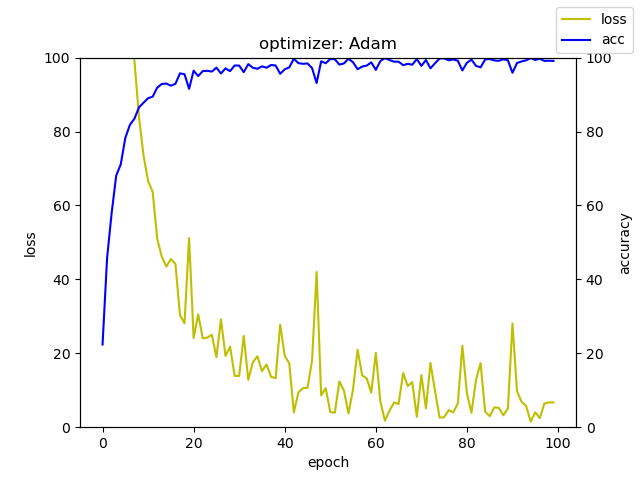

In [14]:

%matplotlib notebook
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(np.asarray(train_loss), 'y')
acc_ax.plot( np.asarray(train_acc),  'b')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.set_ylim([0, 100])

acc_ax.set_ylabel('accuracy')
acc_ax.set_ylim([0, 100])


fig.legend(['loss','acc'], loc='upper right')
plt.title('optimizer: '+TITLE)
plt.savefig('acc_loss.png')
plt.show()

<IPython.core.display.Javascript object>


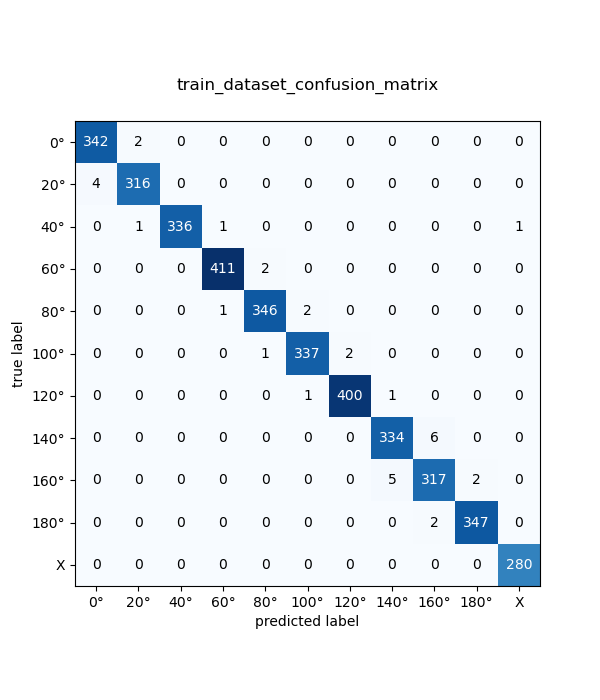

In [15]:
axis = ['0\u00b0','20\u00b0','40\u00b0','60\u00b0','80\u00b0','100\u00b0','120\u00b0','140\u00b0','160\u00b0','180\u00b0','X']
from sklearn.metrics import ConfusionMatrixDisplay as cmd


stacked = torch.stack( ( torch_label[1:], torch_pred[1:] ), dim=1 )
cmt = torch.zeros(11,11, dtype=torch.int32)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] += 1


plot_confusion_matrix(cmt.numpy())
plt.title('train_dataset_confusion_matrix')

plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,7,forward=True)

plt.savefig( 'training_dataset_confusion_matrix2-1.png' )
plt.show()


In [16]:
model.eval().to(device)



with torch.no_grad():
    correct = 0
    total = 0

    #confusion matrix
    torch_pred_valid  = torch.empty((1,), dtype=torch.int32).to(device)
    torch_label_valid = torch.empty((1,), dtype=torch.int32).to(device)

    for data, label in valid_dataset:
        output = model(data)
        preds  = torch.max(output.data, 1)[1]
        total += len(label)
        correct += (preds==label).sum().item()

        #confusion matrix
        torch_pred_valid  = torch.cat( [ torch_pred_valid , preds.to( device, dtype=torch.int32) ], dim=0 )
        torch_label_valid = torch.cat( [ torch_label_valid, label.to( device, dtype=torch.int32) ], dim=0 )


    valid_stacked = torch.stack( ( torch_label_valid[1:], torch_pred_valid[1:] ), dim=1 )

      
    print('Test Accuracy: ', 100.*correct/total)

Test Accuracy:  95.0


<IPython.core.display.Javascript object>


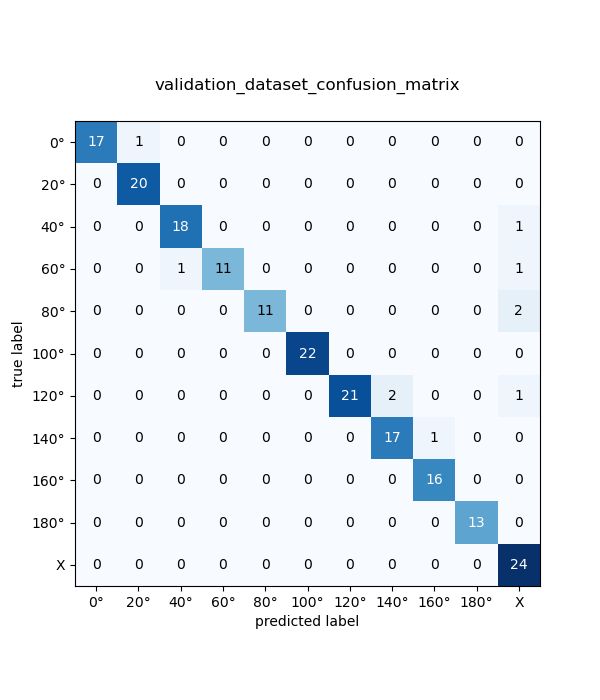

In [17]:
cmt_valid = torch.zeros(11,11, dtype=torch.int32)

for p in valid_stacked:
    tl, pl = p.tolist()
    cmt_valid[tl, pl] += 1


plot_confusion_matrix(cmt_valid.numpy(), cmap='Blues')

plt.title('validation_dataset_confusion_matrix')
plt.xticks(np.arange(11), axis)
plt.yticks(np.arange(11), axis)
plt.gcf().set_size_inches(6,7,forward=True)


plt.savefig( 'validation_dataset_confusion_matrix2-1.png' )
plt.show()